In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, clear_output
from time import sleep
from livelossplot import PlotLosses
import tensorflow as tf
import numpy as np
import seaborn as sns; 
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from scipy.stats import norm, uniform
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
slim = tf.contrib.slim
from tqdm.notebook import tqdm
import sys
from scipy.linalg import block_diag
sys.path.append('../models/')
sys.path.append('../')
from ratio_utils_highdim import *
tf.keras.backend.set_floatx('float32')
print(tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.15.0


In [11]:
n_dims = 320
num_samples=100000
mi = 80
bs=500
N=200
deep=False
reset(1)

def get_rho_from_mi(mi, n_dims):
    """Get correlation coefficient from true mutual information"""
    x = (4 * mi) / n_dims
    return (1 - np.exp(-x)) ** 0.5  # correlation coefficient
        
def get_data(mu_1=0.,mu_2=2.,mu_3=2.,scale_p=0.1,scale_q=0.1,scale_m=1.):
    
    p = tfd.MultivariateNormalFullCovariance(
        loc=mu_1,
        covariance_matrix=scale_p)
    
    q = tfd.MultivariateNormalDiag(
        loc=mu_2,
        scale_diag=scale_q)
      
    m = tfp.distributions.Mixture(
          cat=tfp.distributions.Categorical(probs=[.5,.5]),
          components=[
            p,
            q, 
        ])
    p_samples_ = p.sample([num_samples]) 
    q_samples_ = q.sample([num_samples])
#     alpha = tf.expand_dims(tfd.Uniform (0.,1.).sample([num_samples]),1)
#     m_samples_ = m.sample([num_samples])#(1-alpha)*p_samples_ + alpha*q_samples_ #+ m.sample([num_samples]) #+ m.sample([num_samples])
    alpha = tf.expand_dims(tf.reshape(tf.repeat([0.,0.5,.75,.75,1.],num_samples//5),[num_samples]),1)
    m_samples_ = (1-alpha)*p_samples_ + alpha*q_samples_ #+ m.sample([num_samples]) #+ m.sample([num_samples])
    
    with tf.Session() as sess:
        p_,q_,m_ = sess.run([p_samples_, q_samples_, m_samples_],feed_dict={})
        sess.close() 
    
    return p, q, m, p_,q_,m_

# Define data param
rho = get_rho_from_mi(mi, n_dims)  # correlation coefficient
print(rho)
rhos = np.ones(n_dims // 2, dtype="float32") * rho

mu_1=np.zeros((n_dims), dtype="float32")
mu_2=np.zeros((n_dims), dtype="float32")
mu_3=np.zeros((n_dims), dtype="float32")

scale_p = block_diag(*[[[1, rho], [rho, 1]] for _ in range(n_dims // 2)])
scale_p = np.float32(scale_p)
scale_q = np.ones(n_dims, dtype="float32")
scale_m = 1*np.eye(n_dims, dtype="float32")

# Generate dataset
p, q, m, p_list, q_list, m_list = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)
_, _, _, p_list_test, _, m_list_test = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)

print(p_list.shape)

0.7950600976206501
(100000, 320)


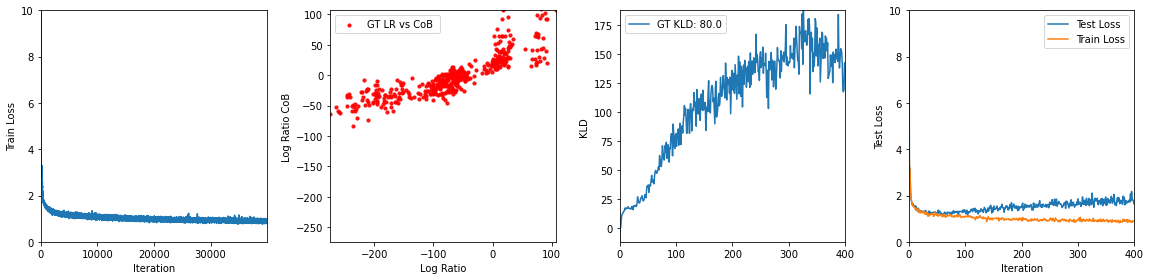

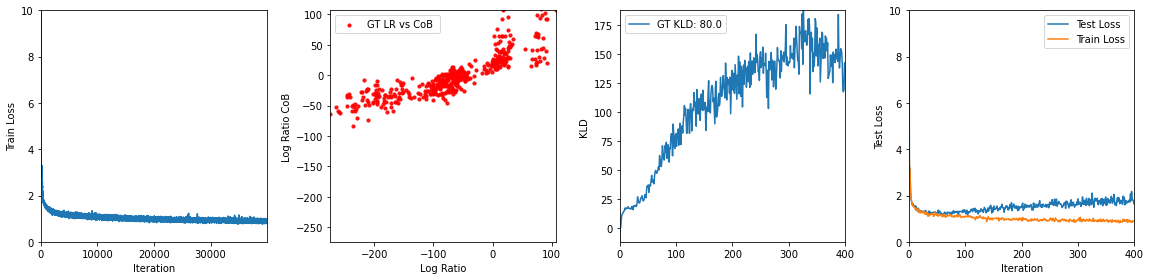

In [12]:
p_samples = tf.placeholder(tf.float32, shape=[None,n_dims])
q_samples = tf.placeholder(tf.float32, shape=[None,n_dims])
m_samples = tf.placeholder(tf.float32, shape=[None,n_dims])

dloss = get_loss(p_samples, q_samples, m_samples, None, deep=deep)
optim = get_optim(dloss,lr=5e-3) #,lr=5e-3,b1=.99

log_ratio_p_q, _ = get_gt_ratio_kl(p,q,m_samples)
_, kl_from_pq = get_gt_ratio_kl(p,q,p_samples)
kl_from_cob = get_kl_from_cob(p_samples)

log_ratio_p_m = get_logits(m_samples,deep=deep, training=False)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
[kl_gt] = sess.run([p.kl_divergence(q)],feed_dict={})

fig, [ax1,ax2,ax3,ax4] = plt.subplots(1, 4,figsize=(16,4))

line, = ax1.plot([0,1],[0,1])
test_line, = ax4.plot([0,1],[0,1],label='Test Loss')
test_line1, = ax4.plot([0,1],[0,1],label='Train Loss')
kld_line, = ax3.plot([0],[0],label='GT KLD: '+str(kl_gt))
x, y = np.random.random((2, 500))

scat = ax2.scatter(x,y,label='GT LR vs CoB ',alpha=0.9,s=10.,c='r')

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Train Loss")
ax1.set_xlim([0,N*(num_samples//bs)])
ax1.set_ylim([0,10])

ax2.set_xlabel("Log Ratio")
ax2.set_ylabel("Log Ratio CoB")
ax2.legend(loc='best')

ax3.set_ylabel("KLD")
ax3.legend(loc='best')

ax4.set_xlabel("Iteration")
ax4.set_ylabel("Test Loss")
ax4.set_xlim([0,N//50])
ax4.set_ylim([0,10])
ax4.legend(loc='best')


plt.tight_layout()
loss_store=[]
test_loss_store=[]
test_loss_store1=[]
kld_store=[]
pbar = range(0,N)
for _ in pbar:
    for i in range(num_samples//bs):
        ps = p_list[np.random.choice(range(len(p_list)),bs)]
        qs = q_list[np.random.choice(range(len(q_list)),bs)]
        ms = m_list[np.random.choice(range(len(m_list)),bs)]
        feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}
        l,_ = sess.run([dloss, optim],feed_dict=feed_dict)
        loss_store.append(l)
        if i%100==0:
            line.set_data(range(len(loss_store)), loss_store)
            ax1.set_xlim( 0, len(loss_store) )
            
            ps = p_list_test[np.random.choice(range(len(p_list_test)),bs)]
            qs = q_list[np.random.choice(range(len(q_list)),bs)]
            ms = m_list_test[np.random.choice(range(len(m_list_test)),bs)]
            feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}
            
            testl, lpq, lpqm, kl_cob = sess.run([dloss, log_ratio_p_q, log_ratio_p_m, kl_from_cob],feed_dict=feed_dict)
            kld_store.append(kl_cob)
            test_loss_store.append(testl)
            test_loss_store1.append(l)
            cob = lpqm[:,0]-lpqm[:,1]
            scat.set_offsets(np.asarray([lpq,cob]).T)
            ax2.set_xlim( lpq.min(), lpq.max() )
            ax2.set_ylim( lpq.min(), lpq.max() )

            kld_line.set_data(range(len(kld_store)),kld_store)
            ax3.set_xlim( 0, len(kld_store) )
            ax3.set_ylim( min(kld_store), max(kld_store) )
            
            test_line.set_data(range(len(test_loss_store)), test_loss_store)
            test_line1.set_data(range(len(test_loss_store1)), test_loss_store1)
            ax4.set_xlim( 0, len(test_loss_store) )

            clear_output(wait=True)
            display(fig)


# sample_and_plot(sess, kld, kl_from_pq, kl_from_cob, p_samples, q_samples, m_samples, log_ratio_p_q, log_ratio_p_m, mu_1, mu_2, scale_p, scale_q, mu_3, scale_m)



    

In [81]:
np.mean(kld_store[-5:])

70.67126

In [82]:
np.std(kld_store[-5:])

6.3173985

In [20]:
def kl(m1, s1, m2, s2):
    return np.log(s2)-np.log(s1)+(s1**2 + (m1-m2)**2)/(2*s2**2)-1/2

In [28]:
kl(0.,1e-6,0,1e-7)

47.197414907005964